# <span style='color:SteelBlue'>P6 - Classifiez automatiquement des biens de consommation (part 1)</span>

<img src="https://user.oc-static.com/upload/2019/02/24/15510259240381_Projet%20textimage%20logo.png" width="600" height="400">

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Description des donnees**
- _1/ etc..._


Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise **"place de marché"** est une entreprise qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits) 
la plus fluide possible, et dans l'optique d'un passage à l'échelle, 
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un 
article (actuellement effectuée manuellement par les vendeurs, donc peu 
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une image et une description pour automatiser l’attribution
de catégorie de l’article. 

2/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle. 

3/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 1ère partie concernant la faisabilité d'un moteur de
classification. Nous allons donc analyser les descriptions textuelles et les
images des produits en réalisant :
-	1 prétraitement des données texte ou image suivant le cas.
-	1 extraction des features par différentes méthodes :
    - Pour les données textuelles :
      - 2 approches de type “bag-of-words” avec comptage simple de mots et Tf-idf
      - 1 approche de type word/sentence embedding classique avec Word2Vec
      - 1 approche de type word/sentence embedding avec BERT
      - 1 approche de type word/sentence embedding avec USE
    - Pour les données images :
      - 1 algorithme de type SIFT/ ORB / SURF
      - 1 algorithme de type CNN Transfer Learning
-	1 réduction en 2 dimensions, afin de projeter les produits sur un
    graphique 2D, sous la forme de points dont la couleur correspondra à la
    catégorie réelle
-	1 analyse graphique pour déduire la faisabilité de regroupement
    automatique. 
-	1 calcul de similarité entre les catégories réelles et les catégories
issues d’une segmentation en clusters pour confirmer mon analyse visuelle.
___
**Source des datasets**<br>
Source : Non précisé<br>
___

<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le
terminal VSC : </b><br>
nbqa black Berthe_Pierrick_1_notebook_exploration_112023.ipynb</div>

# <span style='background:grey'>Importations des librairies</span>

In [119]:
# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# machine learning
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import words
import string
nltk.download('stopwords')

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Sklearn       : " + sklearn.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"Nombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("Code lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le 
terminal VSC : </b> <br>
nbqa black nom_fichier.ipynb</div>

# <span style='background:grey'>Paramètres d'affichage</span>

In [3]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Creation d'1 palette de couleurs
colors_list = [
    "Gold",
    "MediumPurple",
    "DarkOrange",
    "LimeGreen",
    "Tomato",
    "SteelBlue",
    "SaddleBrown",
    "DeepPink",
    "LightSkyBlue",
    "OliveDrab",
]

# Style de la police pour le titre des graphiques
font_title = {
    "family": "Times New Roman",
    "color": "000000",
    "size": 22,
}

# Style de la police pour les axes du graphique
font_axe = {
    "family": "Times New Roman",
    "color": "000000",
    "size": 16,
}

# <span style='background:grey'>Fonctions</span>


In [4]:
def affiche_sample(sub_df, n_samp=10):
    """
    Affiche n_samp documents d'un corpus.

    Paramètres:
    sub_df (pandas.DataFrame): Le DataFrame contenant le corpus de documents.
    n_samp (int, optional): Le nombre de documents à afficher. Par défaut à 10.

    Retours:
    None
    """

    # Sélectionne n_samp documents aléatoirement
    samp = sub_df.sample(n_samp)

    # Affiche les n_samp documents
    for idx, ser in samp.iterrows():
        txt_1 = f"==> product_name : {ser['product_name']}<==\n"
        display(txt_1 + ser['description'] + "..." + "\n\n")

In [5]:
def nettoyage_de_base_pour_texte(text):
    """
    Prétraite une chaîne de caractères en effectuant les opérations suivantes :
    - Conversion en minuscules
    - Suppression de la ponctuation
    - Suppression des espaces de plus d'un espace

    Args:
        text (str): La chaîne de caractères à prétraiter.

    Returns:
        str: La chaîne de caractères prétraitée.
    """
    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = "".join([char for char in text if char not in string.punctuation])

    # Supprimer les espaces de plus d'un espace
    text = " ".join(text.split())

    return text

In [6]:
def afficher_document_temoin(
        df_text,
        df_text_clean,
        text,
        numero_document_temoin):
    """
    Fonction qui affiche un document avant et après le nettoyage.

    Paramètres:
    df_text (pandas.DataFrame): DataFrame contenant les documents avant le
    nettoyage.
    df_text_clean (pandas.DataFrame): DataFrame contenant les documents après
    le nettoyage.
    text (str): Texte à afficher.
    numero_document_temoin (int): Numéro du document témoin à afficher.

    Retourne:
    None
    """
    # Document témoin
    doc_temoin_avant = df_text["description"][numero_document_temoin]
    doc_temoin_apres = df_text_clean["description"][numero_document_temoin]

    # Affichage AVANT
    display(f"AVANT {text} : ")
    display(doc_temoin_avant)

    # Affichage APRES
    display(f"APRES {text} : ")
    display(doc_temoin_apres)

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [7]:
# Definir le chemin
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
data_brut = {}
display("===> Liste des fichiers importes: <====\n")

# POUR chaque fichier
for fichier in fichiers:

    # Traiter uniquement les fichiers .csv
    if fichier.endswith(".csv"):
        display(fichier)

        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(
            chemin + fichier,
            sep=",",
            encoding="utf-8"
        )

'===> Liste des fichiers importes: <====\n'

'flipkart_com-ecommerce_sample_1050.csv'

# <span style='background:blue'>Etape 1 : Présentation du dataset</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons le début, la fin et des échnatillons au hasard du tableau.

In [8]:
fichier = data_brut["flipkart_com-ecommerce_sample_1050.csv"]
fichier.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [9]:
fichier.tail(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [10]:
fichier.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
52,f01140c02fd09e5c56312a64fa8db3da,2016-05-30 10:52:06 +0000,http://www.flipkart.com/cookart-elegant-s-s-ha...,Cookart Elegant S.S. Handi With Hot Pot Pack o...,"[""Kitchen & Dining >> Cookware >> Casserole & ...",CRLEJ6B76SJP8ZVG,945.0,699.0,f01140c02fd09e5c56312a64fa8db3da.jpg,False,Key Features of Cookart Elegant S.S. Handi Wit...,No rating available,No rating available,Cookart,"{""product_specification""=>[{""key""=>""Microwave ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
296,458c697fe5824552890b0e674cf5c109,2016-05-26 23:54:46 +0000,http://www.flipkart.com/ball-ibctdc-160-2gb-dd...,I Ball IBCTDC 160/2gb/DDR2 with Dual Core 2 RA...,"[""Computers >> Computer Peripherals >> CPU >> ...",CPUEJ2CMBFHTTHSJ,12999.0,6990.0,458c697fe5824552890b0e674cf5c109.jpg,False,Specifications of I Ball IBCTDC 160/2gb/DDR2 w...,No rating available,No rating available,I Ball,"{""product_specification""=>[{""key""=>""Processor ..."


Informations sur les features :
- **uniq_id** : identifiant unique du produit
- **crawl_timestamp** :  date de récupération des données
- **product_url** : url du produit 
- **product_name** : nom du produit
- **product_category_tree** : Arborescence pour
    atteindre la catégorie du produit
- **pid** : identifiant de processus ou identifiant perenne
- **retail_price** : prix de vente (monnaie inconnue)
- **discounted_price** : prix de vente avec remise
    (monnaie inconnue)
- **image** : nom du fichier JPEG de l'image du produit
- **is_FK_Advantage_product** : produit avantageux Flipkart (Oui/Non)
- **description** : description du produit
- **product_rating** : note du produit
- **overall_rating** : note globale
- **brand** : marque du produit
- **product_specifications** : spécifications du produit

## <span style='background:green'>2/ Structure</span>

Nous affichons la structure du tableau. Nous comptons également le nombre de
features par type et le nombre de valeurs uniques par feature. 

In [11]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [12]:
fichier.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [13]:
tmp = fichier.nunique()
tmp

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Le fichier contient 1_050 lignes et 15 colonnes. Il y a une majorité de données de type object (12/15). Pour autant, il y a 3 features qui ne sont pas dans le format attendu :
- **crawl_timestamp** : format object au lieu de datetime
- **product_rating** : format object au lieu de int/float
- **overall_rating** : format object au lieu de int/float

## <span style='background:green'>3/ Valeurs manquantes</span>

In [14]:
fichier.isna().sum().sort_values(ascending=False)

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [15]:
missing_values = fichier.isna().mean()
columns_with_na = missing_values[missing_values > 0].sort_values(
    ascending=False)
display(columns_with_na)

brand                     3.22e-01
retail_price              9.52e-04
discounted_price          9.52e-04
product_specifications    9.52e-04
dtype: float64

Il y a 1 valeur manquante dans les features "retail_price", 
"discounted_price", "product_specifications".

Il y a 338 valeurs (1/3) manquantes dans les features "brand".

## <span style='background:green'>4/ Doublons</span>

Nous vérifions tout d'abord qu'il n'y a pas 2 lignes doublons. Puis nous observons les valeurs doublons par feature. 

In [16]:
fichier.duplicated().sum()

0

In [17]:
for col in fichier.columns:
    n = fichier.duplicated(subset=[col]).sum()
    display(f"col : {col} -> duplicated : {n}")

'col : uniq_id -> duplicated : 0'

'col : crawl_timestamp -> duplicated : 901'

'col : product_url -> duplicated : 0'

'col : product_name -> duplicated : 0'

'col : product_category_tree -> duplicated : 408'

'col : pid -> duplicated : 0'

'col : retail_price -> duplicated : 695'

'col : discounted_price -> duplicated : 625'

'col : image -> duplicated : 0'

'col : is_FK_Advantage_product -> duplicated : 1048'

'col : description -> duplicated : 0'

'col : product_rating -> duplicated : 1023'

'col : overall_rating -> duplicated : 1023'

'col : brand -> duplicated : 559'

'col : product_specifications -> duplicated : 65'

Il n'y a pas de ligne doublons. En revanche, il y a des valeurs doublons dans plusieurs features. 

## <span style='background:green'>5/ Inspection des données</span>

Resume des features **quantitatives** :

In [18]:
fichier.describe().round(2)

,retail_price,discounted_price
count,1049.00,1049.00
mean,2186.20,1584.53
std,7639.23,7475.10
min,35.00,35.00
25%,555.00,340.00
50%,999.00,600.00
75%,1999.00,1199.00
max,201000.00,201000.00


Resume des features **qualitatives** : 

In [19]:
fichier.describe(exclude=[np.number, "datetime64[ns]"])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,993,1,889,889,11,22


## <span style='background:green'>6/ Autorisation d'utilisation</span>

Notre client nous a confirmé que les textes et les images sont libres de droit.
Ils peuvent être utilisés et modifiés pour sans aucune contrainte de proriété
intellectuelle.

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 2 : Extraction des features textes</span>

## <span style='background:green'>1/ Nettoyage</span>

### <span style='background:black'>a/ Sélection des features</span>

Voici la feature qui contient une description du produit.

In [20]:
fichier["description"]

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

Voici la feature qui contient la catégorie du produit.

In [21]:
fichier["product_category_tree"]

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

Nous créons un nouveau dataframe avec ces 2 features précédentes.

In [22]:
cols = ["description", "product_category_tree"]
data_raw = fichier[cols]
data_raw.head()

,description,product_category_tree
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


### <span style='background:black'>b/ Détermination de la catégorie du produit</span>

Nous splittons la feature "product_category_tree" pour obtenir uniquement la catégorie principale du produit dans la feature "target".

In [23]:
data_raw.loc[:, 'product_name'] = \
    data_raw.loc[:, 'product_category_tree'].str.split(
        '>>').str[0].str.lstrip('["')
data_raw.head(3)

C:\Users\pierr\AppData\Local\Temp\ipykernel_12860\2766752290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.loc[:, 'product_name'] = \


,description,product_category_tree,product_name
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care


Nous supprimons la feature "product_category_tree" qui ne nous sert plus. 

In [24]:
df_text = data_raw.copy()
df_text.drop("product_category_tree", axis=1, inplace=True)
df_text.head(3)

,description,product_name
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care


### <span style='background:black'>c/ Vérification Nan</span>

Nous vérifions qu'il n'y a aucun Nan dans le dataframe.

In [25]:
df_text.isna().sum()

description     0
product_name    0
dtype: int64

### <span style='background:black'>d/ Vérification doublons</span>

Nous vérifions qu'il n'y a aucun doublon dans le dataframe.

In [26]:
idx = df_text.duplicated(subset="description", keep="first")
idx.sum()

0

## <span style='background:green'>2/ EDA</span>

### <span style='background:black'>a/ Product_name</span>

In [27]:
df_text.product_name.value_counts(normalize=False)

product_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

<Axes: ylabel='count'>

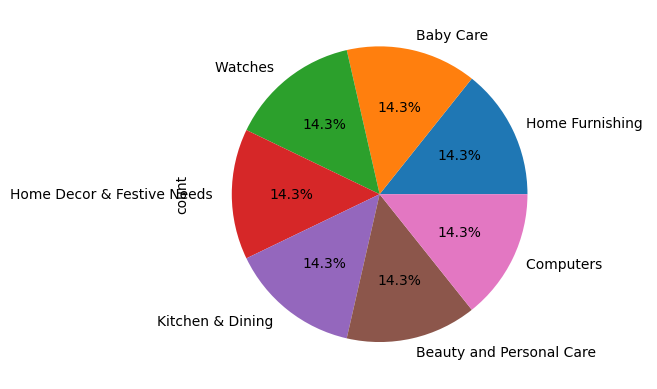

In [28]:
df_text.product_name.value_counts().plot(kind="pie", autopct='%1.1f%%')

La feature "product_name" comprend 7 catégories de produits qui sont toutes réparties équitablement dans le dataframe avec 150 produits par catégorie.

### <span style='background:black'>b/Longueurs des documents</span>

Nous observons la longueur des documents en nombre de mots.

In [29]:
df_text.description.describe()

count                                                  1050
unique                                                 1050
top       Key Features of Elegance Polyester Multicolor ...
freq                                                      1
Name: description, dtype: object

In [30]:
tmp = df_text.description.str.len()
tmp

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

<Axes: xlabel='description'>

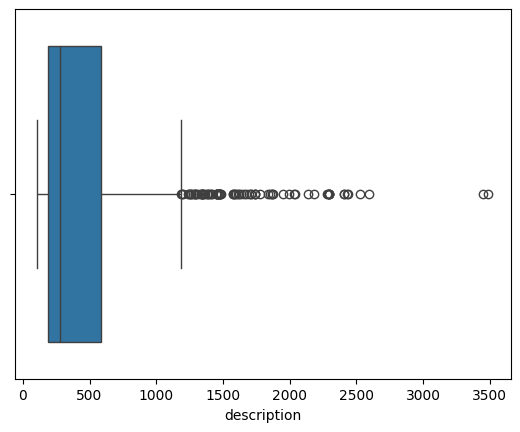

In [31]:
tmp.describe()
sns.boxplot(tmp, orient="h")

<Axes: xlabel='description', ylabel='Count'>

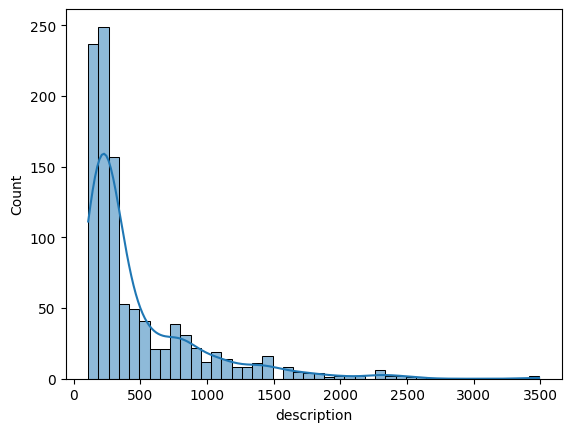

In [32]:
sns.histplot(tmp, kde=True)

Les descriptions sont comprises entre 100 et 3_500 caractères. La majorité des descriptions sont comprises entre 100 et 400 caractères.

### <span style='background:black'>c/Exploration corpus et documents</span>

Nous explorons des documents au hasard.

In [33]:
df_samp = df_text.sample(10, random_state=42)
df_samp

,description,product_name
352,Buy Zyxel PLA-4205 only for Rs. 8100 from Flip...,Computers
689,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb f...,Kitchen & Dining
485,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,Computers
388,Flipkart.com: Buy Anna Andre Paris Set of Dark...,Beauty and Personal Care
31,"Lenco Bdblue Tango Analog Watch - For Men, Bo...",Watches
442,Key Features of Rute Baby Girl's Sleepsuit Fab...,Baby Care
198,Surface180 Wonderful Wooden Antique Drawer Box...,Home Decor & Festive Needs
425,Specifications of Zingalalaa LP-50 50 lm LED C...,Computers
107,Artisan Creation Checkered Single Quilts & Com...,Home Furnishing
714,"Buy Home Originals Abstract, Checkered Double ...",Home Furnishing


In [34]:
affiche_sample(df_samp)

'==> product_name : Beauty and Personal Care <==\nFlipkart.com: Buy Anna Andre Paris Set of Dark Fire & Numero 1 Deodorants Combo Set online only for Rs. 310 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Home Furnishing <==\nArtisan Creation Checkered Single Quilts & Comforters Brown (1 Single Bed Quilt)\r\n                         Price: Rs. 745\r\n\t\t\t\t\r\n\t\t\tPresenting The World Famous Jaipuri Pure Cotton And Velvet Single Bed Razai (Quilt) in Traditional Sanganeri Print of Rajasthan. These Good Looking, Fluffy, Handmade Indian Quilts Are a Specialty of Jaipur. This Spectacular Quilt Will Enhance The Beauty of your Home Decor.Specially designed White check brown quilt made of fine polyfill filling and reversible with one side velvet and having beautifull colour velvet borders.\r\nPresenting The World Famous Jaipuri Pure Cotton And Velvet Single Bed Razai (Quilt) in Traditional Sanganeri Print of Rajasthan. These Good Looking, Fluffy, Handmade Indian Quilts Are a Specialty of Jaipur. This Spectacular Quilt Will Enhance The Beauty of your Home Decor.Specially designed White check brown quilt made of fine polyfill filling and reversible with one side velvet an

'==> product_name : Home Decor & Festive Needs <==\nSurface180 Wonderful Wooden Antique Drawer Box Showpiece  -  20 cm (Wooden, Green)\r\n                         Price: Rs. 1,112\r\n\t\t\t\t\r\n\t\t\tThe vibrant antique drawer Box looks astonishing with alluring carvings and bright colors. Featuring body dimensions of 13 (L) x 10 (W) x 18 (H) cms, it is indeed an amazing home decorative item. The small and compact wooden antique style Box has different golden carvings on each front panel of the drawer and around the drawer Box , which makes it fascinating.\r\n\r\nNote: This is Handcraft Item so each item will be different than other due to limitation of photography.\r\nThe vibrant antique drawer Box looks astonishing with alluring carvings and bright colors. Featuring body dimensions of 13 (L) x 10 (W) x 18 (H) cms, it is indeed an amazing home decorative item. The small and compact wooden antique style Box has different golden carvings on each front panel of the drawer and around the

'==> product_name : Computers <==\nBuy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Kitchen & Dining <==\nBuy Philips 9.5 W LED B22 3000K A55 IND Bulb for Rs.419 online. Philips 9.5 W LED B22 3000K A55 IND Bulb at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

"==> product_name : Baby Care <==\nKey Features of Rute Baby Girl's Sleepsuit Fabric: Cotton Brand Color: Pink,Rute Baby Girl's Sleepsuit Price: Rs. 399 Rute Pink embroidered cotton sleepsuit,Specifications of Rute Baby Girl's Sleepsuit General Details Ideal For Baby Girl's Age Group 0 -  24 month Pattern Embroidered Fabric Cotton Neck Round Neck Sleeve Full Sleeve Bootie Yes Hood No Closure Snap Buttons Number of Contents in Sales Package Pack of 1 Fabric Care Wash with Similar Colors, Use Detergent for Colors Dimensions Length Full In The Box 1 Sleepsuit...\n\n"

'==> product_name : Watches <==\nLenco Bdblue Tango Analog Watch  - For Men, Boys - Buy Lenco Bdblue Tango Analog Watch  - For Men, Boys  Bdblue Online at Rs.599 in India Only at Flipkart.com. Sports Watch, Casual Watch, Big Size Dial, Colourful Strap - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Computers <==\nLapguard Lenovo IdeaPad V470 6 Cell Laptop Battery\r\n                         Price: Rs. 1,799\r\n\t\t\t\t\r\n\t\t\tThe product is compatible with the above mentioned model number.This Lapguard replacement battery is made from high grade cells and highest quality parts. This Lapguard brand replacement battery is 100 percent comparable to original battery in all terms including its size, appearance and most important quality. Each Lapguard laptop battery has to pass strict quality control procedures including filtration and safety testing of voltage, capacity and battery core (body). Each battery also passes necessary authentication certifications like CE, ROHS etc. Before leaving the factory, so you can be rest assured for its quality, durability and performance. Please note that all images are indicative, actual product label may vary. Battery part No./model may not be printed on label.\r\nThe product is compatible with the above mentioned model num

'==> product_name : Home Furnishing <==\nBuy Home Originals Abstract, Checkered Double Blanket Multicolor at Rs. 1299 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Computers <==\nSpecifications of Zingalalaa LP-50 50 lm LED Corded Portable Projector (Multicolor) Performance Features Aspect Ratio 16:09 Color Support 2 Milion Throw Ratio 1.45 3D Support No General Brand Zingalalaa Resolution Native - 480 x 320 Pixel Pixel, Maximum - 1092 x 1080 Pixel Pixel Keystone Correction Automatic Model Number LP-50 Brightness 50 lm Signal Type Pal Projection Distance .5-3.5 m Technology Used BrilliantColor Supported File Format jpeg, BMP, PNG, WMA, MP3, MP4, MPEG1, MPEG2, MPEG4, RMVB, H264, MOV, FLV, DivX, AVI Projection Screen Size .25-2.5 m Color Multicolor Warranty Covered in Warranty Warranty of the product is limited to manufacturing defects only. Warranty Summary 3 Months Replacement Warranty Warranty Service Type Repair / Replacement Not Covered in Warranty Warranty does not cover any external damage Dimensions Weight 550 g Height 8.8 cm Width 11 cm Depth 4 cm Connectivity Features Wireless Network Connectivity No Audio Input/Output

Nous explorons le corpus selon les catégories de "product_name".

In [35]:
# Afficher les différentes catégories
unique_product_name = df_text['product_name'].unique()
display(unique_product_name)

# Créer un dataframe par catégorie
dfs = {}
for product_name in unique_product_name:
    dfs[product_name] = df_text[df_text['product_name'] == product_name]

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [36]:
affiche_sample(dfs[unique_product_name[0]], n_samp=5)

'==> product_name : Home Furnishing <==\nBuy Valtellina Plain Single Top Sheet White at Rs. 1148 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...\n\n'

"==> product_name : Home Furnishing <==\nRustic India Geometric Cushions Cover (Pack of 5, 40 cm, Black)\r\n                         Price: Rs. 799\r\n\t\t\t\t\r\n\t\t\tLet's your guest appreciate your fine taste in home décor as you bring home this 5 pieces cushion covers from Rustic India. Black in color, these cushion covers features an eye catchy geometric print that is hard to notice. The velvet fabric makes it look feathery.\r\nLet's your guest appreciate your fine taste in home décor as you bring home this 5 pieces cushion covers from Rustic India. Black in color, these cushion covers features an eye catchy geometric print that is hard to notice. The velvet fabric makes it look feathery....\n\n"

'==> product_name : Home Furnishing <==\nBuy Baby Bucket Cartoon Single Blanket blue at Rs. 1395 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Home Furnishing <==\nKey Features of Craft Trade Oval Wood Coaster Set Hand Crafted Antique Coaster Apple Shaped Coaster Set,Craft Trade Oval Wood Coaster Set (Brown, Pack of 6) Price: Rs. 299 "Decorate your with this amazing handcrafted Apple shaped coaster set of 6. This coaster set has a been inspired by apple design, which will surely make you fall in love with it. This product has been hand crafted by the artists of Rajasthan and is made up of fine quality wood. It comes with an Apple shaped stand to store it on your table and make it look amazing. It has a long life and will protect you table from stains. Authentic hand Crafted Product from craft Trade Artisans. ",Specifications of Craft Trade Oval Wood Coaster Set (Brown, Pack of 6) General Shape Oval Brand Craft Trade Reversible Yes Design Code CT55 Type Coaster Set Material Wood Style Code WD1001 Pattern Self Design Padding Yes, Wood Color Brown Warranty Covered in Warranty 7 days relacement warranty in cas

'==> product_name : Home Furnishing <==\nBuy Bagru Crafts Cotton Set of Towels at Rs. 490 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...\n\n'

In [37]:
affiche_sample(dfs[unique_product_name[1]], n_samp=5)

"==> product_name : Baby Care <==\nOffspring Embroidered, Solid Single Wrapper White, Pink (1 Wrap)\r\n                         Price: Rs. 310\r\n\t\t\t\t\r\n\t\t\tThis hooded wrap is made from soft material which is gentle against baby's skin.This wrap can be used as a swaddle wrap, burp cloth and much more.\r\nThis hooded wrap is made from soft material which is gentle against baby's skin.This wrap can be used as a swaddle wrap, burp cloth and much more....\n\n"

'==> product_name : Baby Care <==\nBuy Offspring Solid Single Blanket Pink at Rs. 305 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Baby Care <==\nSpecifications of Portia Hat (Pink, Pack of 1) In The Box Number of Contents in Sales Package Pack of 1 General Ideal For Girls...\n\n'

"==> product_name : Baby Care <==\nSpecifications of Beebay Baby Boy's Checkered Casual Shirt General Details Pattern Checkered Occasion Casual Ideal For Baby Boy's Shirt Details Closure Button Sleeve Half Sleeve Number of Contents in Sales Package Pack of 1 Brand Fit Regular Collar Button down collar Fabric Cotton Fit Regular Hem Curved Hem Additional Details Style Code 161207 Fabric Care Machine wash...\n\n"

"==> product_name : Baby Care <==\nSpecifications of NammaBaby Baby Girl's Animal Print Top & Pyjama Set General Details Pattern Animal Print Ideal For Baby Girl's Night Suit Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Type Top & Pyjama Set In the Box 1 Top, 1 Bottom...\n\n"

In [38]:
affiche_sample(dfs[unique_product_name[2]], n_samp=5)

'==> product_name : Watches <==\nTimes 284TMS284 Party-Wedding Analog Watch  - For Women - Buy Times 284TMS284 Party-Wedding Analog Watch  - For Women  284TMS284 Online at Rs.550 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Watches <==\nRana Watches Bw-Prsmd Barbie Analog Watch  - For Girls - Buy Rana Watches Bw-Prsmd Barbie Analog Watch  - For Girls  Bw-Prsmd Online at Rs.199 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Watches <==\nLogues LGSWATCHES760SL Analog Watch  - For Women - Buy Logues LGSWATCHES760SL Analog Watch  - For Women  LGSWATCHES760SL Online at Rs.725 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Watches <==\nHourglass HG 006 Analog Watch  - For Men - Buy Hourglass HG 006 Analog Watch  - For Men  HG 006 Online at Rs.850 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Watches <==\nFluid FS201-BL01 Analog-Digital Watch  - For Women - Buy Fluid FS201-BL01 Analog-Digital Watch  - For Women  FS201-BL01 Online at Rs.999 in India Only at Flipkart.com. Water Resistant, Round Dial, Blue Strap - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...\n\n'

In [39]:
affiche_sample(dfs[unique_product_name[3]], n_samp=5)

'==> product_name : Home Decor & Festive Needs <==\nBuy Unique Design Handcrafted Brass Mini Chair Table Set Showpiece  -  10 cm for Rs.499 online. Unique Design Handcrafted Brass Mini Chair Table Set Showpiece  -  10 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

'==> product_name : Home Decor & Festive Needs <==\nBuy Kaatru Surya Bhagavan Showpiece  -  23.5 cm for Rs.399 online. Kaatru Surya Bhagavan Showpiece  -  23.5 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

'==> product_name : Home Decor & Festive Needs <==\nKey Features of good-night-angel-sleep-well-pics Paper Print Good printing Laminated Water proof Good Paper Quality Long Lasting,good-night-angel-sleep-well-pics Paper Print (18 inch X 12 inch, Framed) Price: Rs. 189 Mega product poster made in high quality hp paper and hd printed, so well art ….,Specifications of good-night-angel-sleep-well-pics Paper Print (18 inch X 12 inch, Framed) Dimensions Paper Depth 300 gsm Weight 100 g Height 18 inch Width 12 inch Poster Details Shape Rectangle Category Humor Black & White Poster No Paper Type Paper Print Paper Finish Matte Lamination Yes Artist Name Mega product Color Poster Yes Frame Details Framed No In the Box Number of Contents in Sales Package 1 Sales Package 1 poster...\n\n'

'==> product_name : Home Decor & Festive Needs <==\nBuy Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm for Rs.21800 online. Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

'==> product_name : Home Decor & Festive Needs <==\nBuy My Angel Gifts Show Piece Showpiece  -  5 cm for Rs.1149 online. My Angel Gifts Show Piece Showpiece  -  5 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

In [40]:
affiche_sample(dfs[unique_product_name[4]], n_samp=5)

'==> product_name : Kitchen & Dining <==\nRockmantra Colorful Ceramic Mug (5.5 l)\r\n                         Price: Rs. 199\r\n\t\t\t\t\r\n\t\t\tGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"\r\nGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"...\n\n'

'==> product_name : Kitchen & Dining <==\nKing International Ergonomic Design with Long Gripped Handle Rolling Pizza Cutter (Stainless Steel Pack of 1)\r\n                         Price: Rs. 199\r\n\t\t\t\t\r\n\t\t\t"Stop fights among friends over the last slice of pizza using this pizza cutten from Fab Kitchen. The suttle color allows it to blend in perfectly with your other kitchen cutlery. The razor sharp stainless steel blade allows it to instantly cut up food slices. Short Description\r\n* Material: Stainless Steel & Plastic\r\n* Color: Red, White and Steel\r\n* Freezer Safe: Yes\r\n* Dishwasher Safe: Yes\r\n* Pizza Cutter Length: 8 inches (20 cm)\r\n* Quantity: 1 Piece (Pizza Cutter)"\r\n"Stop fights among friends over the last slice of pizza using this pizza cutten from Fab Kitchen. The suttle color allows it to blend in perfectly with your other kitchen cutlery. The razor sharp stainless steel blade allows it to instantly cut up food slices. Short Description\r\n* Material: Sta

'==> product_name : Kitchen & Dining <==\nKey Features of giftsthatwow GTW-G-06 Pack of 1 Multipurpose,giftsthatwow GTW-G-06 (600 ml, White, Pack of 1) Price: Rs. 800 Classic Glass For The Royal People,Specifications of giftsthatwow GTW-G-06 (600 ml, White, Pack of 1) General Brand giftsthatwow Model Number GTW-G-06 Type Glass Capacity 600 ml Color White Body & Design Features Material Glass Glass Type Multipurpose In the Box Pack of 1...\n\n'

'==> product_name : Kitchen & Dining <==\nBuy Kalash Kadhai 3.5 L for Rs.549 online. Kalash Kadhai 3.5 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

'==> product_name : Kitchen & Dining <==\nSpecifications of GAYATRI CREATIONS ORANGE KIDS SET 2 Containers Lunch Box (400 ml) General Series BEST OF LUCK Model Name ORANGE KIDS SET Lunch Box Features Lunch Box Material Plastic Number of Containers 2 Lunch Box Capacity 400 ml In the Box 1 LUNCH BOX, 1 WATER BOTTLE...\n\n'

In [41]:
affiche_sample(dfs[unique_product_name[5]], n_samp=5)

'==> product_name : Beauty and Personal Care <==\nKey Features of Allin Exporters Cumin Seed Oil (Co2 Extract) Ideal For: Men, Women Application Area: All Skin Type: Combination Skin Organic Type: Organic,Allin Exporters Cumin Seed Oil (Co2 Extract) (250 ml) Price: Rs. 3,899 Cumin seed oil extract is obtained from the dried seeds of cumin plant, botanically known as Cuminum cyminum, through the method of Co2 extraction method. It is regarded as the best oil for use over joints and muscles to provided an utmost level of relaxation. The use of this oil extract as a massage oil in dilution with carrier oil also helps to provide a soothing feel to mind. In particular, cumin seed oil extract blends perfectly with Chamomile, Angelica, Lavender, Rosemary, Caraway, and other carrier or essential oils.,Specifications of Allin Exporters Cumin Seed Oil (Co2 Extract) (250 ml) In the Box Essential Oil Body & Essential Oil Traits Ideal For Men, Women Application Area All Organic Yes Organic Type Org

'==> product_name : Beauty and Personal Care <==\nFlipkart.com: Buy Wild Stone Red And Juice Combo Set online only for Rs. 390 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Beauty and Personal Care <==\nOxyglow Fruit Massage Cream With Vitamin-E & Almond Under Eye Repair Care (Set of 2)\r\n                         Price: Rs. 464\r\n\t\t\t\t\r\n\t\t\tOxyGlow brings to you a one stop solution to your beauty and cosmetics products catering to all your needs through its wide range of beauty care products like face wash, bleach, face pack, oils, lotions, gels, conditioners, lip and eye care products and many more. So beat your beauty problems with the help of Oxy Glow’s range of beauty products at your ease by ordering them immediately!\r\nOxyGlow brings to you a one stop solution to your beauty and cosmetics products catering to all your needs through its wide range of beauty care products like face wash, bleach, face pack, oils, lotions, gels, conditioners, lip and eye care products and many more. So beat your beauty problems with the help of Oxy Glow’s range of beauty products at your ease by ordering them immediately!...\n\n'

'==> product_name : Beauty and Personal Care <==\nKey Features of Aster Luxury Arabic Oudh Bathing Bar - Pack of 4 SLES FREE: PHTHALATES FREE,Aster Luxury Arabic Oudh Bathing Bar - Pack of 4 (500 g) Price: Rs. 475 Natural Arabic Oudh Soap This luxurious bathing bar has lovable essence of pure Arabian oudh. You will possibly feel more lively & positive after every bath. Agarwood (oud) calms the body and enhances mental functionally. Oudh calms the body, bringing deep tranquility and relaxation. Antimicrobial properties of oud keep skin germs free. The glycerine based soap revives your skin and makes it soft, supple and smooth. Benefits of Arabic Oudh Soap : • Rejuvenative, Anti-stress properties. • Good for dry skin. • Invigorates your skin health. • Moisturizes and smoothens rough skin. Usage: Firmly hold the aster luxury handmade bathing bar and run all over the wet body. This soap gives good lather that will clean your whole body. Apply lather all over body before showering off. Size

'==> product_name : Beauty and Personal Care <==\nBuy Mxofere Combo Papaya Mixfruit Almond Honey Orange Rose Soap Kit for Rs.285 online. Mxofere Combo Papaya Mixfruit Almond Honey Orange Rose Soap Kit at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....\n\n'

In [42]:
affiche_sample(dfs[unique_product_name[6]], n_samp=5)

'==> product_name : Computers <==\nKey Features of Hako 60W Magsafe Laptop Charger For APPLE MacBook Pro13 MB990XA 60 Adapter Designed For: APPLE MacBook Pro13" MB991X/A MAGSAFE,Hako 60W Magsafe Laptop Charger For APPLE MacBook Pro13 MB990XA 60 Adapter Price: Rs. 1,799 Hako laptop adapters come with high quality certification and are compatible with respective brands, all adapters are equipped with protection circuit to protect the laptop all adapters come with 1year warranty.,Specifications of Hako 60W Magsafe Laptop Charger For APPLE MacBook Pro13 MB990XA 60 Adapter General Brand Hako Designed For APPLE MacBook Pro13" MB991X/A MAGSAFE Sales Package 1 Laptop Adapter Model Name APPLE MacBook Pro13" MB991X/A MAGSAFE Model Id 60W Magsafe Laptop Charger For APPLE MacBook Pro13 MB990XA Power Power Consumption (W) 60 W Warranty Covered in Warranty Manufacturing Defects Only Warranty Summary 1 Year Warranty Warranty Service Type To Claim a Warranty Customer needs to contact seller.. Then he 

'==> product_name : Computers <==\nKey Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic lock for safety Four corner elastic straps to keep the device securely tucked inside With Stand to easily watch movies and do a video chat Made of high grade synthetic leather with durable stitching NOTE-This is a universal case for all 7Inch Android Tablets so it features NO CAMERA CUTS moreover please check compatibity with your Tablet as it works through Micro USB  only.,YGS Keyboard Case for Asus Memo Pad 7in Tab (Pink) Price: Rs. 499 YGS Universal QWERTY keyboard for Android Tablet provides you the dual benefit of protecting your Tab as well as providing you with a full functioning keyboard. Intricate stitching makes the case long lasting and durable. The display stand makes it easier for you to write using the keyboard or watch movies on your Tab. The keyboard itself is similar in functionality to netbook keyboards with full QWERTY layout.NOTE-This is 

'==> product_name : Computers <==\nKey Features of JRB 1033 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1033 USB Fan System Requirements: OTG Enabled Android Smart Phone Material: Plastic,Specifications of JRB 1033 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1033 USB Fan (Multicolor) General Brand JRB Type USB Fan System Requirements OTG Enabled Android Smart Phone Material Plastic Model Name 1033 Smallest Mobile Powered By OTG Enabled Android Smart Phone Model ID Portable 1033 Color Multicolor In the Box Sales Package 1 MICRO USB FAN...\n\n'

'==> product_name : Computers <==\nBuy Rega IT Hp Pavilion DV6-6080SF DV6-6081EI 12 Cell 12 Cell Laptop Battery only for Rs. 2499 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...\n\n'

'==> product_name : Computers <==\nTechone+ Flexible SE122103-GREEN USB Led Light (Green)\r\n                         Price: Rs. 449\r\n\t\t\t\t\r\n\t\t\tUsable with Power Bank, Laptop, USB Port Adaptor, USB Multi Pin Board & USB Port Device.\r\nUsable with Power Bank, Laptop, USB Port Adaptor, USB Multi Pin Board & USB Port Device....\n\n'

Nous remarquons qu'il y a des mots propres à chaque catégorie. Par exemple :
- Home Furnishing : sofa, floral, , ...
- Baby care : baby, cotton, ...
- Watches : watch, analog, ...
- Home Decor & Festive Needs : statues, decorative, ...
- Kitchen & Dining : ceramic, mug, ...
- Beauty and Personal Care : cream, massage, ...

A noter que certains mots sont bien entendus présents dans plusieurs catégories.
Nous allons donc devoir faire un nettoyage des données pour supprimer les mots qui ne sont pas pertinents pour la catégorisation.

## <span style='background:green'>3/ pré-traitement</span>

### <span style='background:black'>a/ Nettoyage de base</span>

Nous effectuons un nettoyage de base sur les données textuelles, à savoir :
- Uniformisation de la casse en minuscule
- Suppression de la ponctuaction
- Suppression des espaces inutiles

In [89]:
# Copier le dataframe
df_text_clean = df_text.copy()

# Appliquer la fonction de nettoyage
df_text_clean['description'] = df_text['description'].apply(
    nettoyage_de_base_pour_texte)
df_text_clean['product_name'] = df_text['product_name'].apply(
    nettoyage_de_base_pour_texte)

# Affichage aperçu
df_text_clean.head()

,description,product_name
0,key features of elegance polyester multicolor ...,home furnishing
1,specifications of sathiyas cotton bath towel 3...,baby care
2,key features of eurospa cotton terry face towe...,baby care
3,key features of santosh royal fashion cotton p...,home furnishing
4,key features of jaipur print cotton floral kin...,home furnishing


Nous affichons un document témoin avant et après nettoyage pour vérification.

In [44]:
# Document témoin
numero_document_temoin = 5

# Afficher le comparatif
afficher_document_temoin(
    df_text, df_text_clean, "nettoyage de base", numero_document_temoin)

'AVANT nettoyage de base : '

'Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

'APRES nettoyage de base : '

'maserati time r8851116001 analog watch for boys buy maserati time r8851116001 analog watch for boys r8851116001 online at rs24400 in india only at flipkartcom great discounts only genuine products 30 day replacement guarantee free shipping cash on delivery'

### <span style='background:black'>b/ Tokenisation</span>

Nous séparons chaque document en une liste de mots (tokens).

In [91]:
# copier le dataframe
df_text_token = df_text_clean.copy()

# Appliquer la fonction nltk.word_tokenize
df_text_token['description'] = df_text_clean['description'].apply(
    nltk.word_tokenize)
df_text_token['product_name'] = df_text_clean['product_name'].apply(
    nltk.word_tokenize)

# Agglomérer tous les tokens de la colonne 'description'
corpus = [token for doc in df_text_token['description'] for token in doc] + \
    [token for doc in df_text_token['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_token.head())

'nb tokens 80570, nb unique tokens 6676'

,description,product_name
0,"[key, features, of, elegance, polyester, multi...","[home, furnishing]"
1,"[specifications, of, sathiyas, cotton, bath, t...","[baby, care]"
2,"[key, features, of, eurospa, cotton, terry, fa...","[baby, care]"
3,"[key, features, of, santosh, royal, fashion, c...","[home, furnishing]"
4,"[key, features, of, jaipur, print, cotton, flo...","[home, furnishing]"


Nous affichons un document témoin avant et après tokenisation pour vérification.

In [46]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_clean, df_text_token, "tokenisation", numero_document_temoin)

'AVANT tokenisation : '

'maserati time r8851116001 analog watch for boys buy maserati time r8851116001 analog watch for boys r8851116001 online at rs24400 in india only at flipkartcom great discounts only genuine products 30 day replacement guarantee free shipping cash on delivery'

'APRES tokenisation : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'for',
 'boys',
 'buy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'for',
 'boys',
 'r8851116001',
 'online',
 'at',
 'rs24400',
 'in',
 'india',
 'only',
 'at',
 'flipkartcom',
 'great',
 'discounts',
 'only',
 'genuine',
 'products',
 '30',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'on',
 'delivery']

### <span style='background:black'>c/ Stopwords</span>

Nous supprimons les stopwords (mots sans intérêts) qui ne sont pas pertinents pour la catégorisation.

In [92]:
# copier le dataframe
df_text_sw = df_text_token.copy()

# Charger les stopwords anglais
stop_words = set(stopwords.words("english"))

# Supprimer les stopwords anglais
df_text_sw['description'] = df_text_token['description'].apply(
    lambda doc: [w for w in doc if w not in stop_words])
df_text_sw['product_name'] = df_text_token['product_name'].apply(
    lambda doc: [w for w in doc if w not in stop_words])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_sw['description'] for token in doc] + \
    [token for doc in df_text_token['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_sw.head())

'nb tokens 61499, nb unique tokens 6561'

,description,product_name
0,"[key, features, elegance, polyester, multicolo...","[home, furnishing]"
1,"[specifications, sathiyas, cotton, bath, towel...","[baby, care]"
2,"[key, features, eurospa, cotton, terry, face, ...","[baby, care]"
3,"[key, features, santosh, royal, fashion, cotto...","[home, furnishing]"
4,"[key, features, jaipur, print, cotton, floral,...","[home, furnishing]"


Nous affichons un document témoin avant et après la suppression des stopwords pour vérification.

In [48]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_token,
    df_text_sw,
    "nettoyage des stopwords",
    numero_document_temoin)

'AVANT nettoyage des stopwords : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'for',
 'boys',
 'buy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'for',
 'boys',
 'r8851116001',
 'online',
 'at',
 'rs24400',
 'in',
 'india',
 'only',
 'at',
 'flipkartcom',
 'great',
 'discounts',
 'only',
 'genuine',
 'products',
 '30',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'on',
 'delivery']

'APRES nettoyage des stopwords : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'buy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'india',
 'flipkartcom',
 'great',
 'discounts',
 'genuine',
 'products',
 '30',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'delivery']

### <span style='background:black'>d/ Token omniprésent</span>

Nous comptons le nombre d'occurence de chaque token dans chaque catégorie. 

In [49]:
# dictionnaire des comptages des tokens par catégorie vide
value_counts_cate = {}

# Pour chaque valeur de la feature 'product_name'
for product_name_value in df_text_sw['product_name'].unique():

    # Sélectionner les documents de la catégorie
    df_cate = df_text_sw[
        df_text_sw['product_name'] == product_name_value]['description']

    # Agglomérer tous les tokens de la catégorie
    corpus_par_cate = [token for doc in df_cate for token in doc]

    # Compter les occurences des tokens de la catégorie
    value_counts_cate[product_name_value] = pd.Series(
        corpus_par_cate).value_counts()

    # Afficher le comptage des tokens et aperçu
    display(f"Valeur de la cible : {product_name_value}")
    display(value_counts_cate[product_name_value])

'Valeur de la cible : Home Furnishing '

cm         167
rs         128
cotton      99
pack        88
cover       83
          ... 
form         1
tuft         1
needle       1
removed      1
ac771        1
Name: count, Length: 1179, dtype: int64

'Valeur de la cible : Baby Care '

baby        313
girls       194
cotton      182
details     174
fabric      162
           ... 
chlorine      1
promptly      1
11000026      1
5099          1
rs595         1
Name: count, Length: 1596, dtype: int64

'Valeur de la cible : Watches '

watch        324
analog       249
men          158
day          136
discounts    134
            ... 
rs399          1
rs201000       1
rs593          1
rs770          1
pack           1
Name: count, Length: 708, dtype: int64

'Valeur de la cible : Home Decor & Festive Needs '

cm             277
showpiece      204
1               92
products        92
best            87
              ... 
throughview      1
entrances        1
doors            1
premises         1
685              1
Name: count, Length: 1958, dtype: int64

'Valeur de la cible : Kitchen & Dining '

mug         315
ceramic     204
perfect     143
mugs        130
material    119
           ... 
juice         1
rs2345        1
lemon         1
opaque        1
1butter       1
Name: count, Length: 1502, dtype: int64

'Valeur de la cible : Beauty and Personal Care '

flipkartcom            159
products               130
set                    112
rs                     110
30                     108
                      ... 
coloring                 1
days                     1
afterspecifications      1
213                      1
gown1                    1
Name: count, Length: 1462, dtype: int64

'Valeur de la cible : Computers '

laptop                212
replacement           176
usb                   174
warranty              156
free                  112
                     ... 
flv                     1
withstand               1
abrasions               1
mov                     1
extendersrepeaters      1
Name: count, Length: 1546, dtype: int64

Nous supprimons les tokens qui sont présents dans toutes les catégories.

In [50]:
# Séparer les tokens présents dans chaque les catégories
token_cate = [
    set(value_counts[value_counts >= 1].index)
    for value_counts in value_counts_cate.values()
]

# Sélectionner les tokens présents dans toutes les catégories
token_omni = set.intersection(*token_cate)

print(
    "Nombre de token(s) présent(s) dans toutes les categories",
    len(token_omni),
    "\n")
print("Voici la liste :", token_omni)

Nombre de token(s) présent(s) dans toutes les categories 74 

Voici la liste : {'products', 'india', 'specifications', 'get', 'material', 'white', 'great', '4', 'brand', 'features', 'color', 'quality', 'dimensions', 'width', 'new', 'number', 'well', 'size', '399', 'suitable', 'replacement', 'red', 'delivery', 'weight', 'product', 'may', 'height', '10', 'pink', 'black', 'high', 'shipping', 'life', 'sales', 'blue', '6', 'general', 'designed', 'day', 'look', 'long', 'design', 'vary', 'type', 'body', 'cover', 'package', 'free', 'touch', 'light', 'add', 'buy', 'like', 'g', 'multicolor', 'green', 'contents', 'genuine', '30', 'key', '3', 'rs', 'box', 'one', 'ideal', '1', 'cash', 'price', 'yes', 'water', 'pack', 'comes', 'back', 'style'}


In [93]:
# copier le dataframe
df_text_tomni = df_text_sw.copy()

# Supprimer les tokens omnipresents dans toutes les catégories
df_text_tomni['description'] = df_text_sw['description'].apply(
    lambda doc: [token for token in doc if token not in token_omni])
df_text_tomni['product_name'] = df_text_sw['product_name'].apply(
    lambda doc: [token for token in doc if token not in token_omni])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_tomni['description'] for token in doc]  + \
    [token for doc in df_text_tomni['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_tomni.head())

'nb tokens 45838, nb unique tokens 6486'

,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...","[home, furnishing]"
1,"[sathiyas, cotton, bath, towel, bath, towel, y...","[baby, care]"
2,"[eurospa, cotton, terry, face, towel, set, sma...","[baby, care]"
3,"[santosh, royal, fashion, cotton, printed, kin...","[home, furnishing]"
4,"[jaipur, print, cotton, floral, king, sized, d...","[home, furnishing]"


11:74: E221 multiple spaces before operator


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [52]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_sw,
    df_text_tomni,
    "nettoyage des token omnipresents",
    numero_document_temoin)

'AVANT nettoyage des token omnipresents : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'buy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'india',
 'flipkartcom',
 'great',
 'discounts',
 'genuine',
 'products',
 '30',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'delivery']

'APRES nettoyage des token omnipresents : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discounts',
 'guarantee']

### <span style='background:black'>e/ Longueur de mot</span>

Nous inspectons les tokens qui sont composés que d'un seul caractère.

In [53]:
# Isoler les tokens de 1 lettre
tokens_une_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) == 1
    ]

# Afficher le comptage des tokens et aperçu
tokens_une_lettre_count = pd.Series(tokens_une_lettre).value_counts()
print("Nombre de token a 1 lettre : ", len(tokens_une_lettre_count))
display("Les voici :", tokens_une_lettre_count)

Nombre de token a 1 lettre :  23


'Les voici :'

2    172
x    138
l     84
5     71
8     63
w     45
7     33
•     29
v     27
9     22
0     19
n     18
’     16
u      9
c      8
e      7
b      6
h      4
q      2
–      2
“      2
”      2
�      1
Name: count, dtype: int64

Nous inspectons les tokens qui sont composés de 2 caractères.

In [54]:
# Isoler les tokens de 2 lettres
tokens_deux_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) == 2
    ]

# Afficher le comptage des tokens et aperçu
tokens_deux_lettre_count = pd.Series(tokens_deux_lettre).value_counts()
print("Nombre de token a 2 lettres : ", len(tokens_deux_lettre_count))
display("Voici les 50 les plus fréquents :", tokens_deux_lettre_count.head(50))

Nombre de token a 2 lettres :  145


'Voici les 50 les plus fréquents :'

cm    515
ml    118
12     67
35     58
id     54
mm     54
75     39
15     36
40     34
55     31
18     30
hp     28
60     27
16     27
50     27
13     24
45     24
20     24
65     23
17     22
ce     19
gb     18
95     18
80     16
na     16
kg     16
23     16
go     15
90     15
fs     15
00     14
32     13
34     13
3d     12
ac     11
25     11
14     11
tv     11
28     10
24     10
ft     10
11     10
pc     10
01      8
19      8
69      8
pa      8
44      8
39      8
70      7
Name: count, dtype: int64

Nous inspectons les tokens qui sont composés de 15 caractères et plus.

In [55]:
# Isoler les tokens de 15 lettres et +
tokens_long_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) >= 15
    ]

# Afficher le comptage des tokens et aperçu
tokens_long_lettre_count = pd.Series(tokens_long_lettre).value_counts()
print("Nombre de token a 15 lettres et plus:", len(tokens_long_lettre_count))
display("Voici les 50 les plus fréquents :", tokens_long_lettre_count.head(50))

Nombre de token a 15 lettres et plus: 243


'Voici les 50 les plus fréquents :'

cmspecifications                11
laminationprint                 10
residuespecifications           10
orderspecifications              6
cospecifications                 5
cottonspecifications             5
mjug0151prishaindia              5
christmascoloured                4
glovespecifications              4
warrantyspecifications           4
ducjug010ducgl0122               4
ruchikainternational             4
9825000000000001                 3
multifunctional                  3
thnkss…specifications            3
scratchresistant                 3
alinespecifications              3
showerantiqueshop                3
lgswatches760sl                  3
stockspecifications              3
lookspecifications               3
onespecifications                3
plasticspecifications            3
responsibilityspecifications     3
lifeisnotliving                  3
leagueoflegends                  3
decorationthese                  3
wearspecifications               3
megnetledsportblackr

Nous remarquons que les tokens composés de 1 ou 2 lettres ne sont pas pertinents pour la catégorisation.

Ceux composés de 15 lettres et plus sont des mots composés qui ne sont pas pertinents pour la catégorisation.

Nous allons donc les supprimer.

In [56]:
# Concatener les 3 listes de tokens a supprimer
tokens_une_deux_long_lettre = list(set(
    tokens_une_lettre + tokens_deux_lettre + tokens_long_lettre))

# Afficher le nombre de tokens a supprimer
print(
    "Nombre de tokens differents a supprimer :",
    len(tokens_une_deux_long_lettre))

Nombre de tokens differents a supprimer : 411


In [94]:
# copier le dataframe
df_text_long = df_text_tomni.copy()

# Supprimer les tokens de 1, 2 et 15 lettres et +
df_text_long['description'] = df_text_tomni['description'].apply(
    lambda doc: [w for w in doc if w not in tokens_une_deux_long_lettre])
df_text_long['product_name'] = df_text_tomni['product_name'].apply(
    lambda doc: [w for w in doc if w not in tokens_une_deux_long_lettre])

# Agglomérer tous les tokens de la colonne 'description'
corpus = [token for doc in df_text_long['description'] for token in doc] + \
    [token for doc in df_text_long['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_token.head())

'nb tokens 42805, nb unique tokens 6075'

,description,product_name
0,"[key, features, of, elegance, polyester, multi...","[home, furnishing]"
1,"[specifications, of, sathiyas, cotton, bath, t...","[baby, care]"
2,"[key, features, of, eurospa, cotton, terry, fa...","[baby, care]"
3,"[key, features, of, santosh, royal, fashion, c...","[home, furnishing]"
4,"[key, features, of, jaipur, print, cotton, flo...","[home, furnishing]"


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [58]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_tomni,
    df_text_long,
    "nettoyage des token trop court ou trop long",
    numero_document_temoin)

'AVANT nettoyage des token trop court ou trop long : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discounts',
 'guarantee']

'APRES nettoyage des token trop court ou trop long : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discounts',
 'guarantee']

Il n'a aucun token composé de moins de 3 lettres ou 15 lettres et plus dans l'exemple ci-dessus.

Nous affichons donc un autre exemple où il y a des tokens composés de moins de 3 lettres ou 15 lettres et plus.

In [59]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_tomni,
    df_text_long,
    "nettoyage des token trop court ou trop long",
    numero_document_temoin=229)

'AVANT nettoyage des token trop court ou trop long : '

['surface',
 '180',
 'elephant',
 'shape',
 'handpainted',
 'wooden',
 'round',
 'stool',
 'showpiece',
 '1778',
 'cm',
 'rs4704',
 'online',
 'surface',
 '180',
 'elephant',
 'shape',
 'handpainted',
 'wooden',
 'round',
 'stool',
 'showpiece',
 '1778',
 'cm',
 'best',
 'prices',
 'guarantee']

'APRES nettoyage des token trop court ou trop long : '

['surface',
 '180',
 'elephant',
 'shape',
 'handpainted',
 'wooden',
 'round',
 'stool',
 'showpiece',
 '1778',
 'rs4704',
 'online',
 'surface',
 '180',
 'elephant',
 'shape',
 'handpainted',
 'wooden',
 'round',
 'stool',
 'showpiece',
 '1778',
 'best',
 'prices',
 'guarantee']

Nous remarquons que les tokens de 2 lettres ('cm') ont bien été supprimés.

### <span style='background:black'>f/ Lemmatisation</span>

La **lemmatisation** réduit les mots à leur forme de base en tenant compte du contexte et de la partie du discours du mot. Par exemple, le mot "better" serait réduit à "good" par la lemmatisation, car "better" est un comparatif de "good". La lemmatisation utilise un vocabulaire et une analyse morphologique des mots pour obtenir un résultat plus précis et plus correct sur le plan linguistique.

In [98]:
# copier le dataframe
df_text_lem = df_text_long.copy()

# Appliquer la lemmatisation sur tous les tokens
trans = WordNetLemmatizer()
df_text_lem['description'] = df_text_long['description'].apply(
    lambda doc: [trans.lemmatize(token) for token in doc])
df_text_lem['product_name'] = df_text_long['product_name'].apply(
    lambda doc: [trans.lemmatize(token) for token in doc])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_lem['description'] for token in doc] + \
    [token for doc in df_text_lem['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_lem.head())

'nb tokens 42805, nb unique tokens 5702'

,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...","[home, furnishing]"
1,"[sathiyas, cotton, bath, towel, bath, towel, y...","[baby, care]"
2,"[eurospa, cotton, terry, face, towel, set, sma...","[baby, care]"
3,"[santosh, royal, fashion, cotton, printed, kin...","[home, furnishing]"
4,"[jaipur, print, cotton, floral, king, sized, d...","[home, furnishing]"


Nous affichons un document témoin avant et après la lemmatisation pour vérification.

In [61]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_long,
    df_text_lem,
    "la lemmatisation",
    numero_document_temoin)

'AVANT la lemmatisation : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discounts',
 'guarantee']

'APRES la lemmatisation : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discount',
 'guarantee']

### <span style='background:black'>g/ Stemming</span>

Le **stemming** réduit les mots à leur racine ou à leur forme de base en supprimant les préfixes et les suffixes. Par exemple, les mots "running", "runner", et "ran" seraient tous réduits à "run" par le stemming. Cependant, le stemming peut parfois être trop agressif et réduire les mots à une forme qui n'est pas un mot réel. Par exemple, "argument" pourrait être réduit à "argu".

In [99]:
# copier le dataframe
df_text_stem = df_text_long.copy()

# Appliquer la lemmatisation sur tous les tokens
trans = PorterStemmer()
df_text_stem['description'] = df_text_long['description'].apply(
    lambda doc: [trans.stem(token) for token in doc])
df_text_stem['product_name'] = df_text_long['product_name'].apply(
    lambda doc: [trans.stem(token) for token in doc])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_stem['description'] for token in doc] + \
    [token for doc in df_text_stem['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_stem.head())

'nb tokens 42805, nb unique tokens 5149'

,description,product_name
0,"[eleg, polyest, abstract, eyelet, door, curtai...","[home, furnish]"
1,"[sathiya, cotton, bath, towel, bath, towel, ye...","[babi, care]"
2,"[eurospa, cotton, terri, face, towel, set, sma...","[babi, care]"
3,"[santosh, royal, fashion, cotton, print, king,...","[home, furnish]"
4,"[jaipur, print, cotton, floral, king, size, do...","[home, furnish]"


Nous affichons un document témoin avant et après le stemming pour vérification.

In [63]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_long,
    df_text_stem,
    "le stemming",
    numero_document_temoin)

'AVANT le stemming : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boys',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discounts',
 'guarantee']

'APRES le stemming : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'r8851116001',
 'onlin',
 'rs24400',
 'flipkartcom',
 'discount',
 'guarante']

Nous choississons d'utiliser la **lemmatisation** plutôt que le stemming car elle est plus précise.

Elle permet de conserver le sens des mots et de ne pas créer de mots qui n'existent pas. Les performances sur les tâches de NLP à venir n'est sera que meilleur.

D'ailleurs nous remarquons que la lemmatisation a permis de créer un corpus plus diversifié que le stemming: 
<br>=> unique token : 5_702 Vs. 5_149 respectivement.

Le principal inconvénient de la lemmatisation est la durée de calcul qui est plus longue par rapport au stemming, mais ce n'est pas un problème dans notre cas puisque nous n'avons que 1_050 documents. La durée de calcul n'est pas trop longue pour être bloquante. 

### <span style='background:black'>h/ Vérification mots anglais</span>

Nous utilisons la méthode **words** de la librairie **nltk** pour vérifier que tous les mots sont bien en anglais.

In [64]:
# Uniformiser la casse en minuscule
eng_words = [i.lower() for i in words.words()]

# Compter le nombre de mots différents
len(set(eng_words))

234377

Cette méthode contient une liste de plus de 234_000 mots anglais. Nous comparons les mots de notre corpus avec cette liste pour en retenir que les mots anglais.

In [100]:
# copier le dataframe
df_text_eng = df_text_lem.copy()

# Supprimer les tokens omnipresents dans toutes les catégories
df_text_eng['description'] = df_text_lem['description'].apply(
    lambda doc: [token for token in doc if token in eng_words])
df_text_eng['product_name'] = df_text_lem['product_name'].apply(
    lambda doc: [token for token in doc if token in eng_words])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_eng['description'] for token in doc] + \
    [token for doc in df_text_eng['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_eng.head())

'nb tokens 33154, nb unique tokens 3070'

,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...","[home, furnishing]"
1,"[cotton, bath, towel, bath, towel, yellow, bat...","[baby, care]"
2,"[cotton, terry, face, towel, set, small, inch,...","[baby, care]"
3,"[royal, fashion, cotton, printed, king, sized,...","[home, furnishing]"
4,"[print, cotton, floral, king, sized, double, p...","[home, furnishing]"


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [66]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_lem,
    df_text_eng,
    "nettoyage des tokens non anglais",
    numero_document_temoin)

'AVANT nettoyage des tokens non anglais : '

['maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'maserati',
 'time',
 'r8851116001',
 'analog',
 'watch',
 'boy',
 'r8851116001',
 'online',
 'rs24400',
 'flipkartcom',
 'discount',
 'guarantee']

'APRES nettoyage des tokens non anglais : '

['time', 'watch', 'boy', 'time', 'watch', 'boy', 'discount', 'guarantee']

## <span style='background:green'>4/ Vectorisation de texte</span>

### <span style='background:black'>a/ Bag of Words</span>

#### <span style='background:purple'>=> Comptage simple de mot</span>

Nous créons tout d'abord un bag of words avec la méthode **CountVectorizer** de la librairie **sklearn** sur les tokens contenus dans la feature "description".

In [132]:
# Passer tous les tokens en string
df_text_eng["description"] = df_text_eng["description"].astype(str)
df_text_eng["product_name"] = df_text_eng["product_name"].astype(str)

# Créer CountVectorizer
vectorizer = CountVectorizer()

# fit CountVectorizer avec le vocab et transform en matrice de termes-document
X_ft_descrip = vectorizer.fit_transform(df_text_eng["description"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_ft_descrip_df = pd.DataFrame(
    X_ft_descrip.toarray(), columns=vocab["token"])
display(X_ft_descrip_df)

token,ability,able,abode,abrasion,abroad,absolute,absorbency,absorbent,absorber,absorbing,abstract,accent,access,accessory,accident,accidental,accommodate,according,acer,ache,aching,acid,acne,across,acrylic,...,wrapped,wrapper,wring,wrinkle,wrist,write,wrought,yarn,year,yellow,yet,yield,york,youd,young,youth,youthful,youve,yr,zero,zinc,zip,zipper,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Meme version mais avec des methodes de nettoyage supplémentaires : seuil de fréquence de mots et normalisation des mots.

In [133]:
# Passer tous les tokens en string
df_text_eng["description"] = df_text_eng["description"].astype(str)
df_text_eng["product_name"] = df_text_eng["product_name"].astype(str)

# Créer CountVectorizer avec seuil de fréquence et  normalisation des mots
vectorizer = CountVectorizer(min_df=0.01, max_df=0.95, lowercase=True)

# fit CountVectorizer avec le vocab et transform en matrice de termes-document
X_ft_descrip_nett_supp = vectorizer.fit_transform(df_text_eng["description"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_ft_descrip_nett_supp_df = pd.DataFrame(
    X_ft_descrip_nett_supp.toarray(), columns=vocab["token"])
display(X_ft_descrip_nett_supp_df)

token,abstract,accessory,actual,adapter,additional,adorable,affordable,age,also,aluminium,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,bag,base,bath,...,used,video,vinyl,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,waterproof,way,wear,wide,wireless,without,woman,wood,wooden,work,would,year,yellow,yet
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,2,0,0,0,8,0,0,0,2,0,0,0,0,0,0,0,0,...,0,2,3,0,6,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Nous créons ensuite un bag of words sur les tokens contenus dans la feature "description" + "product_name".

In [134]:
# Concaténez "description" et "product_name" dans une nouvelle feature
df_text_eng["combined"] = \
    df_text_eng["description"] + " " + df_text_eng["product_name"]
display(df_text_eng.head())

# Créer CountVectorizer
vectorizer = CountVectorizer()

# fit CountVectorizer avec le vocab et transform en matrice de termes-document
X_ft_tous = vectorizer.fit_transform(df_text_eng["combined"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_ft_tous_df = pd.DataFrame(
    X_ft_tous.toarray(), columns=vocab["token"])
display(X_ft_tous_df)

,description,product_name,combined
0,"['elegance', 'polyester', 'abstract', 'eyelet'...","['home', 'furnishing']","['elegance', 'polyester', 'abstract', 'eyelet'..."
1,"['cotton', 'bath', 'towel', 'bath', 'towel', '...","['baby', 'care']","['cotton', 'bath', 'towel', 'bath', 'towel', '..."
2,"['cotton', 'terry', 'face', 'towel', 'set', 's...","['baby', 'care']","['cotton', 'terry', 'face', 'towel', 'set', 's..."
3,"['royal', 'fashion', 'cotton', 'printed', 'kin...","['home', 'furnishing']","['royal', 'fashion', 'cotton', 'printed', 'kin..."
4,"['print', 'cotton', 'floral', 'king', 'sized',...","['home', 'furnishing']","['print', 'cotton', 'floral', 'king', 'sized',..."


token,ability,able,abode,abrasion,abroad,absolute,absorbency,absorbent,absorber,absorbing,abstract,accent,access,accessory,accident,accidental,accommodate,according,acer,ache,aching,acid,acne,across,acrylic,...,wrapped,wrapper,wring,wrinkle,wrist,write,wrought,yarn,year,yellow,yet,yield,york,youd,young,youth,youthful,youve,yr,zero,zinc,zip,zipper,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Meme version mais avec des methodes de nettoyage supplémentaires : seuil de fréquence de mots et normalisation des mots.

In [135]:
# Concaténez "description" et "product_name" dans une nouvelle feature
df_text_eng["combined"] = \
    df_text_eng["description"] + " " + df_text_eng["product_name"]
display(df_text_eng.head())

# Créer CountVectorizer avec seuil de fréquence et  normalisation des mots
vectorizer = CountVectorizer(min_df=0.01, max_df=0.95, lowercase=True)

# fit CountVectorizer avec le vocab et transform en matrice de termes-document
X_ft_tous_nett_supp = vectorizer.fit_transform(df_text_eng["combined"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_ft_tous_nett_supp_df = pd.DataFrame(
    X_ft_tous_nett_supp.toarray(), columns=vocab["token"])
display(X_ft_tous_nett_supp_df)

,description,product_name,combined
0,"['elegance', 'polyester', 'abstract', 'eyelet'...","['home', 'furnishing']","['elegance', 'polyester', 'abstract', 'eyelet'..."
1,"['cotton', 'bath', 'towel', 'bath', 'towel', '...","['baby', 'care']","['cotton', 'bath', 'towel', 'bath', 'towel', '..."
2,"['cotton', 'terry', 'face', 'towel', 'set', 's...","['baby', 'care']","['cotton', 'terry', 'face', 'towel', 'set', 's..."
3,"['royal', 'fashion', 'cotton', 'printed', 'kin...","['home', 'furnishing']","['royal', 'fashion', 'cotton', 'printed', 'kin..."
4,"['print', 'cotton', 'floral', 'king', 'sized',...","['home', 'furnishing']","['print', 'cotton', 'floral', 'king', 'sized',..."


token,abstract,accessory,actual,adapter,additional,adorable,affordable,age,also,aluminium,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,bag,base,bath,...,used,video,vinyl,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,waterproof,way,wear,wide,wireless,without,woman,wood,wooden,work,would,year,yellow,yet
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,0,1,0,0,0,...,4,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,2,0,0,0,8,0,0,0,2,0,0,0,0,1,0,0,0,...,0,2,3,0,6,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Nous créons enfin un bag of words qu'on entraine sur les tokens de "product_name" et qu'on transforme sur tous les tokens du corpus.

#### <span style='background:red'>=> voir avec mentor</span>

Ca ne marche pas : ValueError: Shape of passed values is (1050, 3070), indices imply (1050, 12)

In [136]:
# # Créer un objet CountVectorizer
# vectorizer = CountVectorizer()

# # fit sur product_name et transformer en matrice de termes-document
# vectorizer.fit(df_text_eng["product_name"])
# X_f_prod_t_tous = vectorizer.transform(df_text_eng["combined"])

# # Matrice avec tout le vocab du corpus
# vocab = pd.DataFrame(
#     vectorizer.get_feature_names_out(), columns=["token"])

# # Matrice de termes-document sous forme d'un df
# X_ft_tous_df = pd.DataFrame(
#     X_ft_tous.toarray(), columns=vocab["token"])
# display(X_ft_tous_df)

#### <span style='background:purple'>=> tf-idf</span>


Nous créons un bag of words avec la méthode **TfidfVectorizer** de la librairie **sklearn** sur les tokens contenus dans la feature "description" + "product_name".

In [137]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vocabulary of the corpus and transform into a term-document matrix
Xidf_ft_tous = vectorizer.fit_transform(df_text_eng["combined"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Term-document matrix in the form of a df
Xidf_ft_tous_df = pd.DataFrame(
    Xidf_ft_tous.toarray(), columns=vocab["token"])
display(Xidf_ft_tous_df)

token,ability,able,abode,abrasion,abroad,absolute,absorbency,absorbent,absorber,absorbing,abstract,accent,access,accessory,accident,accidental,accommodate,according,acer,ache,aching,acid,acne,across,acrylic,...,wrapped,wrapper,wring,wrinkle,wrist,write,wrought,yarn,year,yellow,yet,yield,york,youd,young,youth,youthful,youve,yr,zero,zinc,zip,zipper,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


La meme version mais avec des methodes de nettoyage supplémentaires : seuil de fréquence de mots et normalisation des mots.

In [138]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95, lowercase=True)

# Fit the vocabulary of the corpus and transform into a term-document matrix
Xidf_ft_tous_nett_supp = vectorizer.fit_transform(df_text_eng["combined"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Term-document matrix in the form of a df
Xidf_ft_tous_nett_supp_df = pd.DataFrame(
    Xidf_ft_tous_nett_supp.toarray(), columns=vocab["token"])
display(Xidf_ft_tous_nett_supp_df)

token,abstract,accessory,actual,adapter,additional,adorable,affordable,age,also,aluminium,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,bag,base,bath,...,used,video,vinyl,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,waterproof,way,wear,wide,wireless,without,woman,wood,wooden,work,would,year,yellow,yet
0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.63,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.00,0.22,0.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.12,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.14,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.05,0.00,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.06,0.08,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.06,0.00,0.00,0.0,0.00,0.0,0.0,0.05,0.00,0.06,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.29,0.1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.00,...,0.17,0.00,0.00,0.0,0.71,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1046,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.0,0.59,0.0,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.00,...,0.00,0.16,0.21,0.0,0.41,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1047,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.19,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1048,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.12,0.0,0.0,0.00,...,0.00,0.00,0.39,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0


# <span style='background:blue'>Etape 3 : Réduction dimensionnelle</span>

### Réduction de dimension PCA

In [186]:
from sklearn import manifold, decomposition

display(X_ft_descrip_nett_supp_df.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(X_ft_descrip_nett_supp_df)
display(feat_pca.shape)

(1050, 378)

(1050, 216)

In [201]:
feat_pca_df = pd.DataFrame(
    feat_pca, columns=[f"pca_{i}" for i in range(1, feat_pca.shape[1] + 1)])
feat_pca_df["class"] = df_text["product_name"]
feat_pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,...,pca_193,pca_194,pca_195,pca_196,pca_197,pca_198,pca_199,pca_200,pca_201,pca_202,pca_203,pca_204,pca_205,pca_206,pca_207,pca_208,pca_209,pca_210,pca_211,pca_212,pca_213,pca_214,pca_215,pca_216,class
0,-8.47e-03,0.12,-0.02,1.27,-0.09,2.71,-0.29,-0.36,0.83,0.58,-0.79,-0.05,0.77,6.87,-3.58,5.99,-4.87,-3.43,4.81,1.62,-2.56,-0.07,-3.01,-1.04,0.41,...,0.30,0.03,-0.16,0.29,-0.02,-0.07,-0.20,0.29,-0.19,-0.09,7.84e-02,-0.07,0.02,-3.52e-02,-0.01,1.91e-02,2.48e-01,-0.04,-1.02e-01,-1.64e-03,1.67e-01,-0.20,-0.14,-0.04,Home Furnishing
1,-8.80e-01,-0.52,1.48,1.46,-0.46,2.12,-0.08,1.52,-3.81,0.21,4.44,1.86,-0.07,-0.70,-1.63,2.20,2.73,-0.65,-0.02,-0.48,-0.88,-0.20,1.12,-0.09,-0.43,...,-0.18,0.05,0.12,0.12,0.34,-0.07,-0.12,-0.15,-0.10,-0.20,-8.55e-03,-0.27,-0.20,1.16e-01,-0.12,2.02e-01,2.53e-01,0.06,8.14e-02,-2.13e-01,5.60e-02,0.06,-0.14,0.05,Baby Care
2,-1.18e+00,-0.62,4.59,5.31,-0.36,3.41,0.14,2.42,-8.04,0.18,8.22,5.76,-3.35,-0.50,-0.31,-0.59,0.23,-0.87,0.68,-0.98,-0.33,-0.90,-0.56,-2.47,1.04,...,0.13,-0.17,0.12,0.10,-0.04,0.07,-0.12,-0.13,0.03,0.16,8.07e-02,0.05,-0.25,3.47e-02,0.15,1.87e-01,-1.80e-01,-0.08,1.96e-03,-1.25e-02,-1.27e-03,0.10,-0.17,0.04,Baby Care
3,-8.63e-01,-0.54,3.52,2.93,-0.54,5.50,-0.11,4.57,-2.42,-1.15,-2.65,-3.69,0.30,-1.33,-1.01,-0.74,-0.21,0.04,-1.33,-0.49,-1.08,-1.86,0.19,-0.29,-0.65,...,-0.06,-0.15,0.17,-0.09,0.12,-0.04,-0.12,0.30,0.22,-0.16,-1.39e-01,-0.04,0.21,2.37e-03,-0.19,-5.45e-03,5.23e-03,0.33,-3.60e-02,-1.46e-01,-3.88e-01,-0.10,-0.13,0.02,Home Furnishing
4,-6.95e-01,0.37,5.03,5.13,-0.26,7.48,-0.52,6.85,-2.18,-1.75,-3.38,-5.57,-0.01,-0.39,-1.12,-2.28,1.05,0.98,-0.22,2.25,-1.56,-0.73,0.13,-0.57,0.16,...,-0.09,0.19,-0.15,0.03,-0.10,0.31,-0.02,-0.25,-0.06,0.02,-7.55e-02,-0.02,0.01,-1.55e-01,0.07,3.94e-02,-1.83e-02,-0.14,1.76e-01,2.01e-01,8.83e-02,-0.09,-0.01,0.16,Home Furnishing


C:\Users\pierr\AppData\Local\Temp\ipykernel_12860\3403659965.py:1: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='pca_1', ylabel='pca_2'>

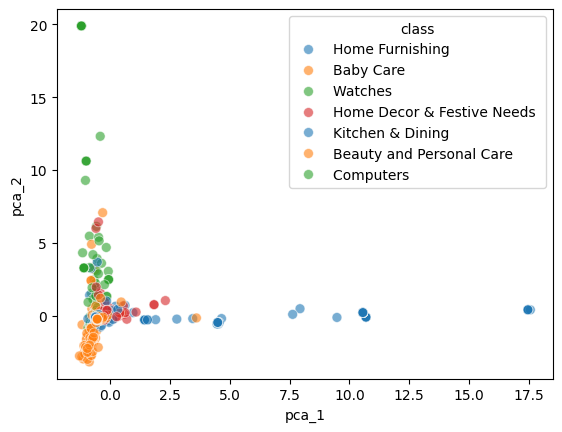

In [203]:
sns.scatterplot(
    x="pca_1",
    y="pca_2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=feat_pca_df,
    legend="brief")

### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [195]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

6:80: E501 line too long (95 > 79 characters)


### Comparaison t-NSE et catégories réelles

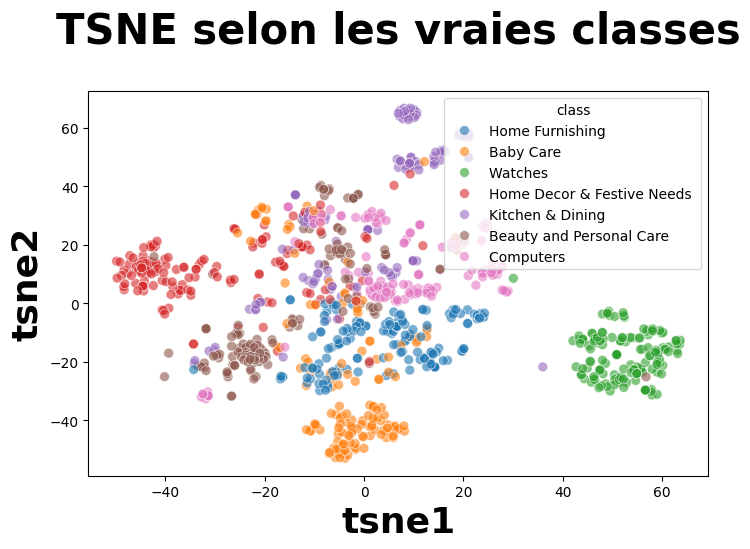

15:13: E251 unexpected spaces around keyword / parameter equals
15:15: E251 unexpected spaces around keyword / parameter equals
15:23: E251 unexpected spaces around keyword / parameter equals
15:25: E251 unexpected spaces around keyword / parameter equals
15:40: E251 unexpected spaces around keyword / parameter equals
15:42: E251 unexpected spaces around keyword / parameter equals
16:29: E251 unexpected spaces around keyword / parameter equals
16:31: E251 unexpected spaces around keyword / parameter equals
16:46: E251 unexpected spaces around keyword / parameter equals
16:48: E251 unexpected spaces around keyword / parameter equals
17:29: E251 unexpected spaces around keyword / parameter equals
17:31: E251 unexpected spaces around keyword / parameter equals
17:46: E251 unexpected spaces around keyword / parameter equals
17:48: E251 unexpected spaces around keyword / parameter equals


In [174]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_text['product_name']

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title(
    'TSNE selon les vraies classes',
    fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')

plt.show()

### Création de clusters à partir de la PCA et affichage des images selon clusters


In [212]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Définir le nombre de clusters
n_clusters = 7

# Créer un objet KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)

# Appliquer KMeans aux données PCA et calculer le score de silhouette
feat_pca_df_without_class = feat_pca_df.drop('class', axis=1)
kmeans.fit(feat_pca_df_without_class)
labels = kmeans.labels_
silhouette_score = silhouette_score(feat_pca_df_without_class, labels)

# Comparez les performances des deux méthodes
display(f'Silhouette score : {silhouette_score}')

'Silhouette score : 0.38766180626382024'

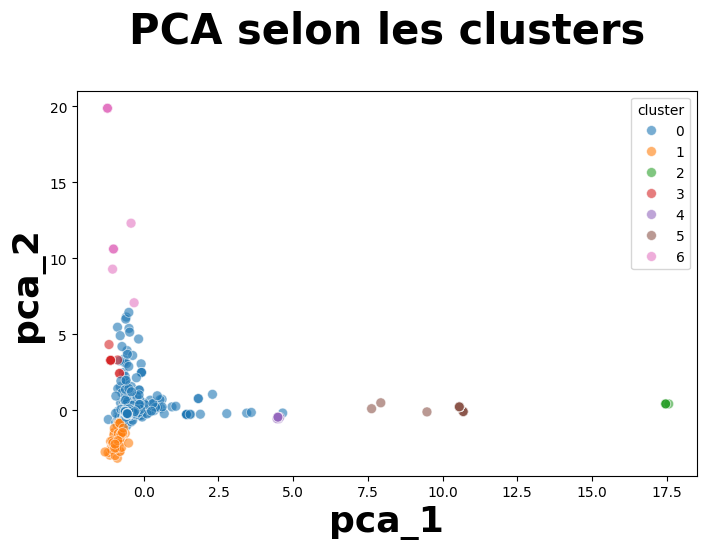

5:22: E231 missing whitespace after ','
13:45: E251 unexpected spaces around keyword / parameter equals
13:47: E251 unexpected spaces around keyword / parameter equals
13:55: E251 unexpected spaces around keyword / parameter equals
13:57: E251 unexpected spaces around keyword / parameter equals
13:72: E251 unexpected spaces around keyword / parameter equals
13:74: E251 unexpected spaces around keyword / parameter equals
13:80: E501 line too long (81 > 79 characters)
14:29: E251 unexpected spaces around keyword / parameter equals
14:31: E251 unexpected spaces around keyword / parameter equals
14:46: E251 unexpected spaces around keyword / parameter equals
14:48: E251 unexpected spaces around keyword / parameter equals
15:29: E251 unexpected spaces around keyword / parameter equals
15:31: E251 unexpected spaces around keyword / parameter equals
15:46: E251 unexpected spaces around keyword / parameter equals
15:48: E251 unexpected spaces around keyword / parameter equals


In [221]:
from sklearn import cluster, metrics

feat_pca_df_without_class["cluster"] = kmeans.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=feat_pca_df_without_class,
    legend="brief")

plt.title('PCA selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('pca_1', fontsize = 26, fontweight = 'bold')
plt.ylabel('pca_2', fontsize = 26, fontweight = 'bold')

plt.show()

labels = df_tsne["class"]
print("ARI : ", metrics.adjusted_rand_score(labels, kmeans.labels_))

Compétence OCR:

Prétraiter des données non structurées de type texte en prenant en compte les normes liées à la propriété intellectuelle et réaliser un feature engineering adapté aux modèles d'apprentissage afin d’obtenir un jeu de données exploitables.

~~CE1 Le candidat a nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)~~

~~CE2 Le candidat a écrit une fonction permettant de “tokeniser” une phrase~~.

~~CE3 Le candidat a écrit une fonction permettant de “stemmer” une phrase.~~

~~CE4 Le candidat a écrit une fonction permettant de “lemmatiser” une phrase.~~

~~CE5 Le candidat a construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.~~

~~CE6 Le candidat a testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.~~

CE7 Le candidat, en complément de la démarche de type “bag-of-words”, a mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).

~~CE8 Le candidat s’assure que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.~~